In [52]:
import pandas as pd
from pandas_profiling import ProfileReport
import json
import numpy as np
from seaborn import heatmap
from pprint import pprint as p
import os
import sys
import subprocess
from jinja2.loaders import FileSystemLoader
from latex.jinja2 import make_env
from latex import build_pdf
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

# Load data
fn = 'tweets_01-08-2021.json'

with open(fn, encoding='utf-8') as f:
    df = pd.read_json(f)

# Drop retweets
df = df.loc[df.isRetweet == 'f']
df.drop(['isRetweet'], axis=1, inplace=True)

# Drop noise due to links, utterannces, etc.
def map_fn(text):
    
    len_text = len(text.strip().split(" "))
    
    if len_text > 4:
        return False
    else:
        return True
    
noise_idx = df.text.map(map_fn)
noise = df.loc[noise_idx]
print(noise_idx.sum())
print(np.invert(noise_idx).sum())

df = df.loc[np.invert(noise_idx)].reset_index(drop=True)
df.sort_values(by=['retweets'], ascending=False, inplace=True)
p(df.info())
p(df.head())

4012
42682
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42682 entries, 4653 to 15708
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         42682 non-null  int64         
 1   text       42682 non-null  object        
 2   isDeleted  42682 non-null  object        
 3   device     42682 non-null  object        
 4   favorites  42682 non-null  int64         
 5   retweets   42682 non-null  int64         
 6   date       42682 non-null  datetime64[ns]
 7   isFlagged  42682 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 2.9+ MB
None
                        id                                               text  \
4653   1311892190680014800  Tonight, @FLOTUS and I tested positive for COV...   
29868   795954831718498300                 TODAY WE MAKE AMERICA GREAT AGAIN!   
20348   474134260149157900  Are you allowed to impeach a president for gro...   
40453  115

In [53]:
# Initialize new columns to false
features = [
    'isLie', 
    'isOpposite', 
    'isPreemptive', 
    'isElection', 
    'isIKnowYouAreButWhatAmI', 
    'isRacist', 
    'isHitler',
    'isPresident',
    'isRussia',
    'isUkraine',
    'isChina',
    'isIran',
    'isNuke',
    'isExecutivePrivilege',
    'isBusiness',
    'isPersonal',
    'isSmear',
    'isSexist',
    'isCelebrity',
    'isPentagon',
    'isNickname',
    'isXenophobic',
    'isMAGA',
    'isReligious',
    'isPandemic',
    'isAllCaps',
    'isRINO',
    'isFirstImpeachment',
    'isSecondImpeachment',
    'isSoTrue',
    'isInTwoWeeks',
    'isWitchHunt',
    'isANTIFA',
    'isBLM',
    'isLove'
]

# Initialize new columns to false
df[features] = 'f'

feature_list = ['maga', 'make america great again']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature)
    is_magazine = df['text'].str.lower().str.contains('magazine')
    df.loc[is_maga, 'isMAGA'] = 't'
    df.loc[is_magazine, 'isMAGA'] = 'f'
print(df['isMAGA'].str.contains('t').sum())

# Populate witch hunt column
feature_list = ['witch hunt']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature)
    df.loc[is_maga, "isWitchHunt"] = 't'
print(df['isWitchHunt'].str.contains('t').sum())

# Populate in two weeks column
feature_list = ['two weeks', 'next week']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature)
    df.loc[is_maga, 'isInTwoWeeks'] = 't'
print(df['isInTwoWeeks'].str.contains('t').sum())

# Populate is so true column
feature_list = ['true.', 'so true']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature)
    df.loc[is_maga, 'isSoTrue'] = 't'
print(df['isSoTrue'].str.contains('t').sum())

# Populate president column
for feature in feature_list:
    is_maga = df['date'] > '2017-01-20'
    df.loc[is_maga, 'isPresident'] = 't'
print(df['isPresident'].str.contains('t').sum())

# Populate all caps column
for feature in feature_list:
    is_maga = df['text'].str.isupper()
    df.loc[is_maga, 'isAllCaps'] = 't'
print(df['isAllCaps'].str.contains('t').sum())

# Populate is Russia column
feature_list = ['russia', 'russian']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature)
    df.loc[is_maga, 'isRussia'] = 't'
print(df['isRussia'].str.contains('t').sum())

# Populate is Ukraine column
feature_list = ['ukraine', 'ukrainian']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature) 
    df.loc[is_maga, 'isUkraine'] = 't'
print(df['isUkraine'].str.contains('t').sum())

# Populate is china column
feature_list = ['china', 'chinese']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature) 
    df.loc[is_maga, 'isChina'] = 't'
print(df['isChina'].str.contains('t').sum())

# Populate is iran column
feature_list = ['iran', 'iranian']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature) 
    df.loc[is_maga, 'isIran'] = 't'
print(df['isIran'].str.contains('t').sum())

# Populate is blm column
feature_list = ['blm', 'black lives matter']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature) 
    df.loc[is_maga, 'isBLM'] = 't'
print(df['isBLM'].str.contains('t').sum())

# Populate is antifa column
feature_list = ['antifa']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature) 
    df.loc[is_maga, 'isANTIFA'] = 't'
print(df['isANTIFA'].str.contains('t').sum())

# Populate is love column
feature_list = ['love', 'loves']
for feature in feature_list:
    is_maga = df['text'].str.lower().str.contains(feature) 
    df.loc[is_maga, 'isLove'] = 't'
print(df['isLove'].str.contains('t').sum())

p(df.columns.values)

1002
350
109
835
14209
137
564
158
998
408
13
28
1589
array(['id', 'text', 'isDeleted', 'device', 'favorites', 'retweets',
       'date', 'isFlagged', 'isLie', 'isOpposite', 'isPreemptive',
       'isElection', 'isIKnowYouAreButWhatAmI', 'isRacist', 'isHitler',
       'isPresident', 'isRussia', 'isUkraine', 'isChina', 'isIran',
       'isNuke', 'isExecutivePrivilege', 'isBusiness', 'isPersonal',
       'isSmear', 'isSexist', 'isCelebrity', 'isPentagon', 'isNickname',
       'isXenophobic', 'isMAGA', 'isReligious', 'isPandemic', 'isAllCaps',
       'isRINO', 'isFirstImpeachment', 'isSecondImpeachment', 'isSoTrue',
       'isInTwoWeeks', 'isWitchHunt', 'isANTIFA', 'isBLM', 'isLove'],
      dtype=object)


In [54]:
# # Print tweets randomized for viewing
# df['merged_id_text'] = df['id'].astype(str) + ': ' + df['date'].astype(str) + ': '+ df['text'] + ': retweets= ' + df['retweets'].astype(str)
# is_maga.merged_id_text.reset_index(drop=True).to_json('high_rt_tweets.json')
# is_maga.info()

In [55]:
# Load labels from more_features.json

with open('more_features.json') as f:
    feature_dict = json.load(f)
                                  
for k, v in feature_dict.items():
    idx = df.loc[df['id'] == int(k)].index
    
    for feature in v:
        df.loc[idx, feature] = 't'

label_df = df.loc[df['id'].isin(feature_dict.keys())].copy()

print(df['isLie'].str.contains('t').sum())
print(df['isSmear'].str.contains('t').sum())
print((df['isLie'].str.contains('t') & df['isElection'].str.contains('t')).sum())


165
110
132


In [56]:
# Retain text, id, date, device
text_df = label_df.loc[:, ['id', 'text', 'date', 'device']]

# Drop columns not represented in the data, except twitter columns.
twitter_columns = [
    'isRetweet', 
    'isDeleted', 
    'favorites', 
    'retweets', 
    'isFlagged'
]

feature_set = set([item for val in feature_dict.values() for item in val])
valid_features = list((set(features).intersection(feature_set)) | set(twitter_columns))

# Drop invalid columns
drop_columns = set(label_df.columns).difference(set(valid_features))
label_df.drop(list(drop_columns), axis=1, inplace=True)
p(label_df.columns.values)

array(['isDeleted', 'favorites', 'retweets', 'isFlagged', 'isLie',
       'isOpposite', 'isPreemptive', 'isElection', 'isRacist', 'isHitler',
       'isPresident', 'isRussia', 'isExecutivePrivilege', 'isSmear',
       'isCelebrity', 'isPentagon', 'isNickname', 'isXenophobic',
       'isPandemic', 'isAllCaps', 'isWitchHunt'], dtype=object)


In [57]:
# Convert T/F to binary

def map_fn(tf_str):
    if tf_str == 't':
        return 1
    else:
        if tf_str == 'f':
            return 0
        else:
            return tf_str
    
for col in label_df:
    label_df.loc[:, col] = label_df[col].map(map_fn)
    
label_df.head()

,isDeleted,favorites,retweets,isFlagged,isLie,isOpposite,isPreemptive,isElection,isRacist,isHitler,...,isRussia,isExecutivePrivilege,isSmear,isCelebrity,isPentagon,isNickname,isXenophobic,isPandemic,isAllCaps,isWitchHunt
4653,0,1869706,408866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
29868,0,498035,281289,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20348,0,231077,237674,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
40453,0,821423,226235,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33769,0,534338,217199,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [58]:
profile = ProfileReport(label_df, title="Labeled Trump Tweets")
profile.to_file("label_profile_report.html")
profile.to_notebook_iframe()

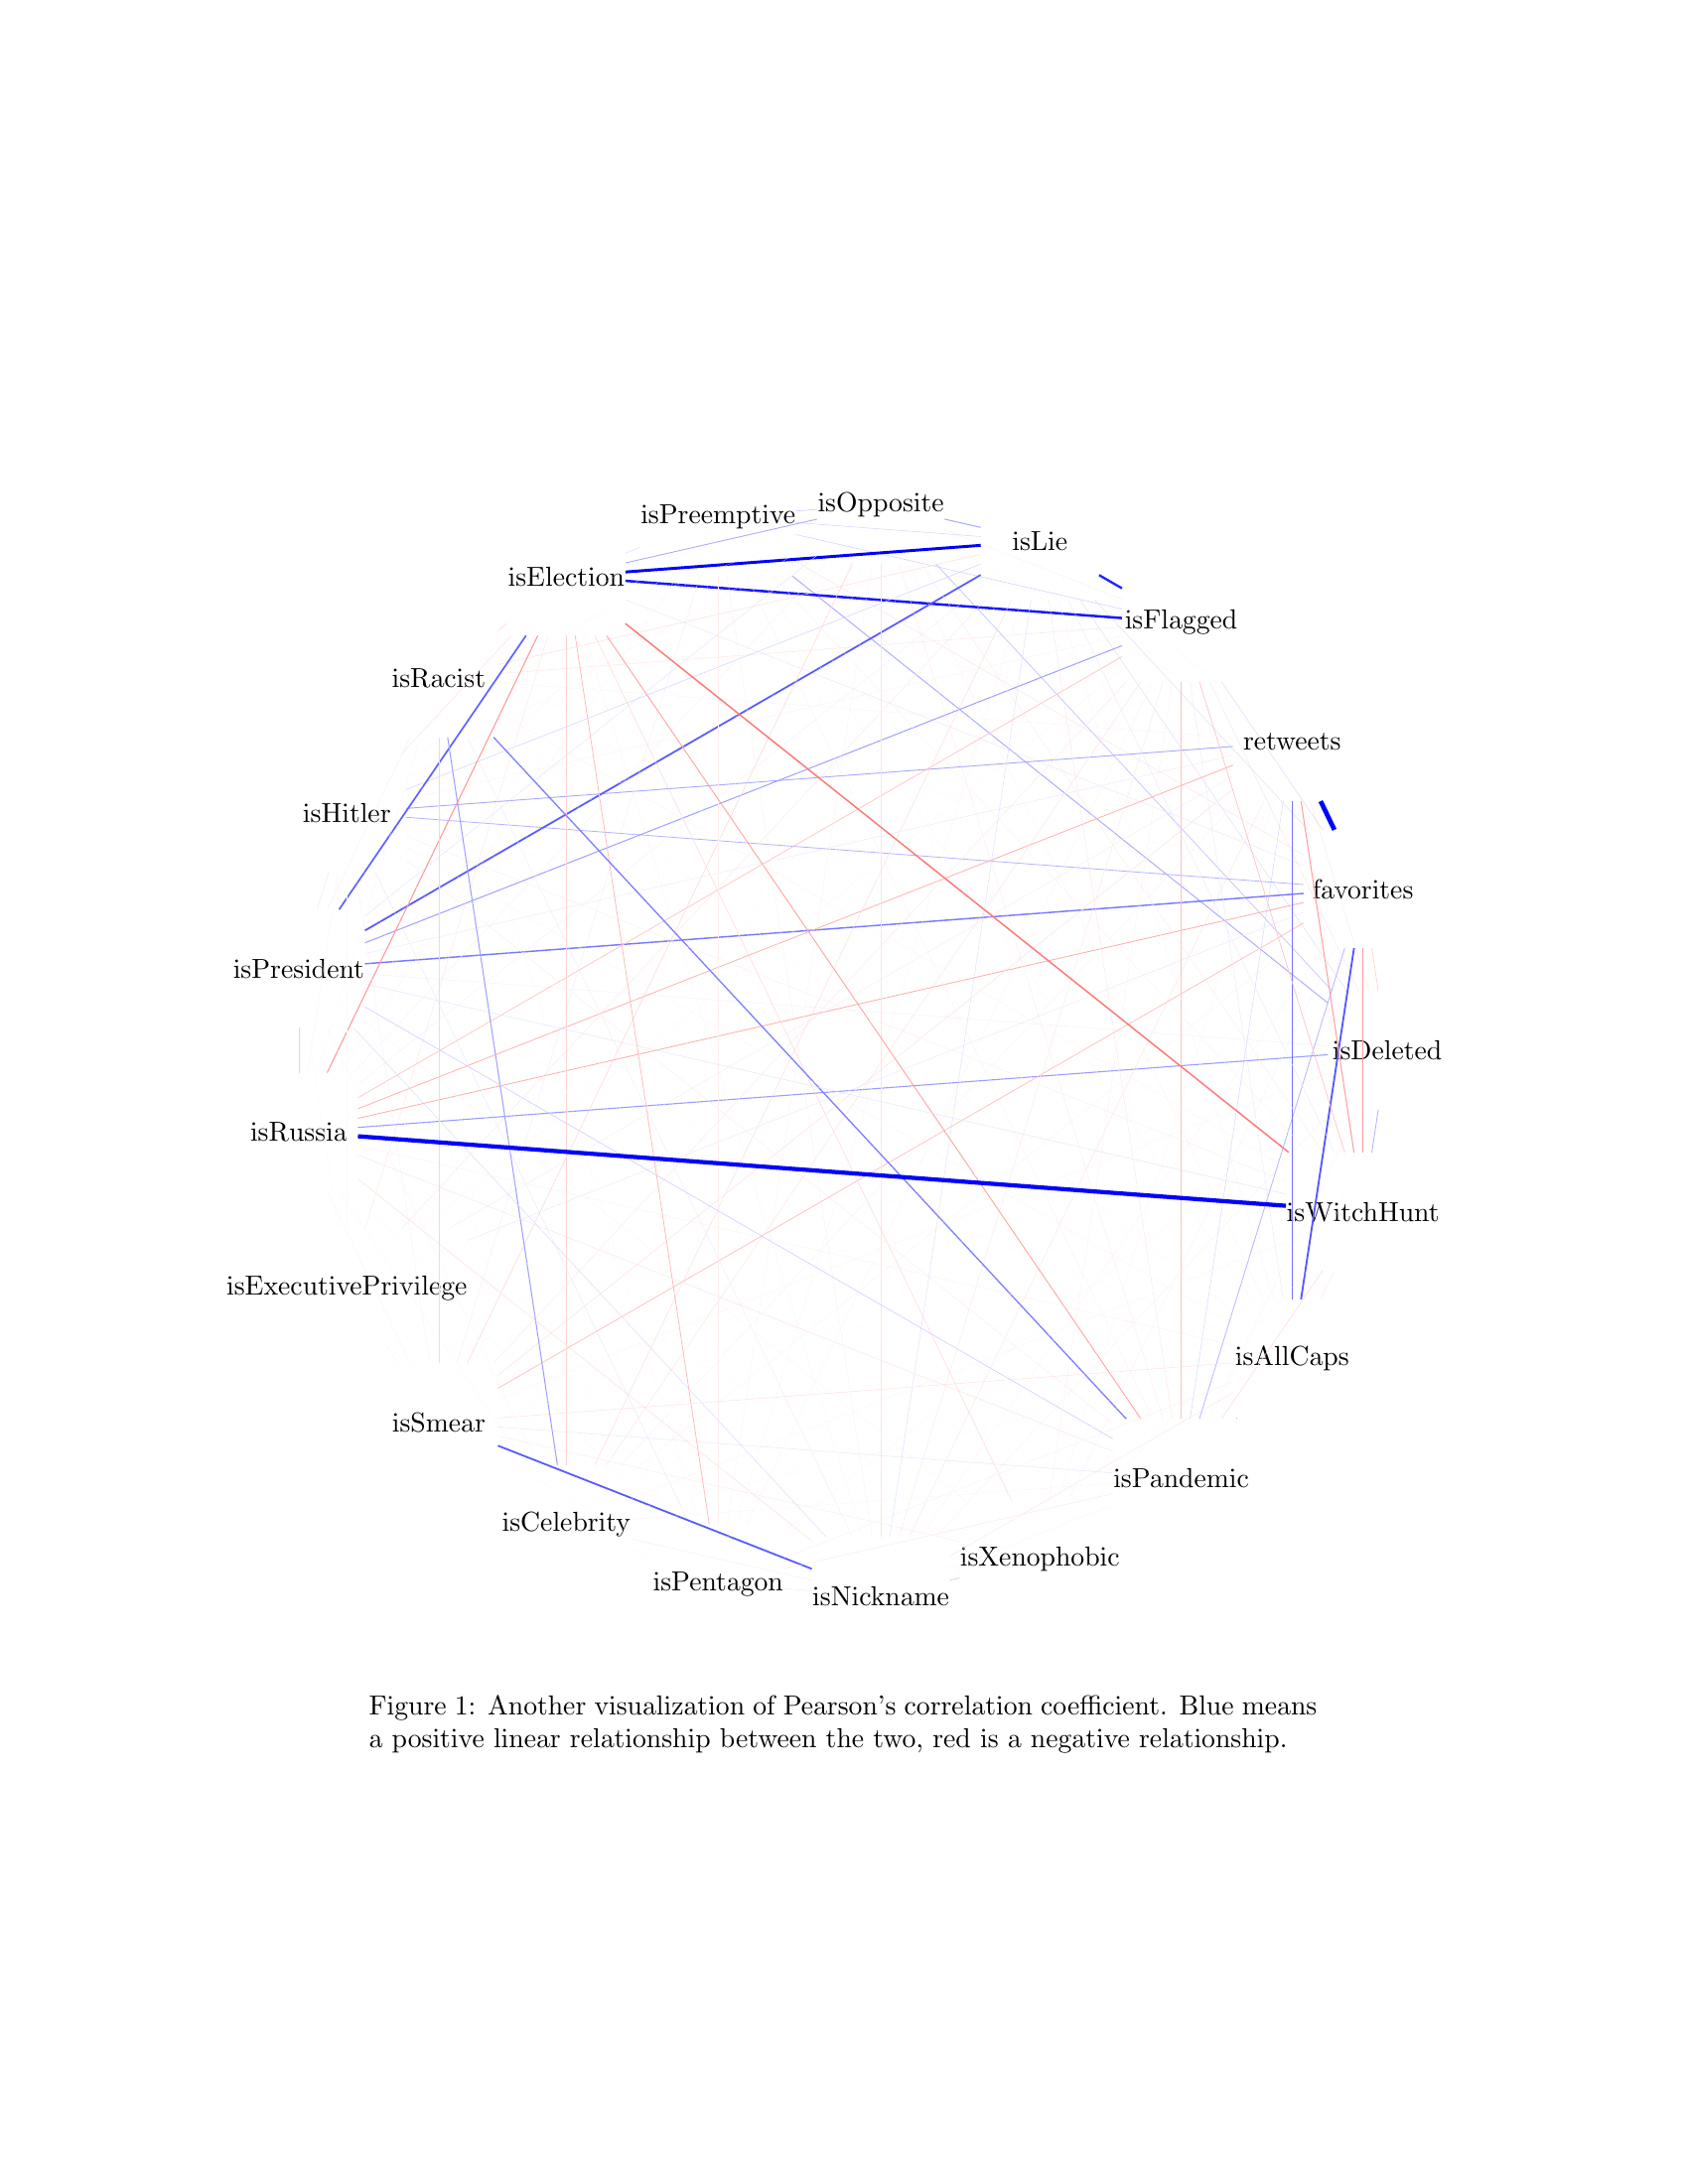

In [59]:
# Display graph of interactions

latex = '''
\\documentclass{article}
\\usepackage {nopageno}
\\usepackage{tikz}
\\usetikzlibrary{bayesnet}
\\usepackage{pgfplotstable}

\\begin{document}

'''

features = label_df.columns.values
layout_rad = np.arange(0.0, 2*np.pi, 2*np.pi/len(features))
xshift = np.cos(layout_rad)*7
yshift = np.sin(layout_rad)*7
corr_matrix = label_df.corr().values

tabular_str = ''
for i in range(len(features)):
    for j in range(len(features)):
        if j > 0:
            tabular_str += ' & '
        tabular_str += str(corr_matrix[i, j])
    tabular_str += ' \\\\\n '

# Matrix view
table = '''
\\begin{{table}}[ht]
\\begin{{center}}
\\begin{{tabular}}{{*{{10}}{{R}}}}
{tabular_str}
\\end{{tabular}}
\\caption{{Pearson''s correlation coefficient. Blue means a positive linear relationship between the two, red is a negative relationship.}}
\\end{{center}}
\\end{{table}}
'''.format(tabular_str=tabular_str)

# latex += table

# Graph view
graph = '\\begin{figure} \\hspace{-1.9cm} \\begin{tikzpicture}[x=3.8cm, y=3.8cm] '
for x, y, feature in zip(xshift, yshift, features):
    graph += '\\node[const] ({feature}) [xshift={x}cm, yshift={y}cm, minimum size=1.5cm] {{{feature}}}; '.format(x=x, y=y, feature=feature)

for i in range(corr_matrix.shape[0]):
    for j in range(i):
        corr = corr_matrix[i, j]
        
        if corr < 0:
            color = 'red!{corr}!white'.format(corr=corr*-200)
        else:
            color = 'blue!{corr}!white'.format(corr=corr*200)
        
        graph += '\\edge [-, color={color}, line width={thickness}pt] {{{feature1}}} {{{feature2}}}; '.format(color=color, feature1=label_df.columns.values[i], feature2=label_df.columns.values[j], thickness=np.abs(corr)*2)

with open ('tex/correlation_graph.tex', 'w') as f:
    f.write(graph + ' \\end{tikzpicture} ')

latex += graph + ' \\end{tikzpicture} '
latex += '\\caption{Another visualization of Pearson\'s correlation coefficient. Blue means a positive linear relationship between the two, red is a negative relationship.} '
latex += '\\end{figure} \\end{document}'

# Compile latex
with open('tex/corr_latex.tex', 'w') as f:
    f.write(latex)
pdf = build_pdf(latex)
pdf.save_to('tex/correlation_graph.pdf')
   
images = convert_from_path('tex/correlation_graph.pdf')
for i in range(len(images)):
    display(images[i])
